In [73]:
import requests
import pandas as pd 
import numpy as np 
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import itertools
from statsmodels.sandbox.stats.runs import runstest_1samp
import matplotlib.ticker as mtick

In [9]:
####### Helper functions

# Clean line of output from API
def clean_line(line): 
    line = line.replace('"', '')
    line = line.replace('[', '')
    line = line.replace(']', '')
    
    return line

# Clean df of unwanted data
def clean_df(df):
    temp_df = df.copy()
    temp_df = temp_df[temp_df.event.isin(['Rated Blitz game', 'Rated Rapid game'])]
    temp_df = temp_df[temp_df.variant=='Standard']
    temp_df = temp_df[(temp_df.white_elo * 1.2 > temp_df.black_elo) & (temp_df.black_elo * 1.2 > temp_df.white_elo)]
    
    return temp_df

# Create 3 lagged versions for the prev game, 2 prev games, 3 prev games
def get_lagged_df(df):
    
    # Lag df multiple times
    df_lag_1 = df[['date', 'points']].shift(-1)
    df_lag_2 = df[['date', 'points']].shift(-2)
    df_lag_3 = df[['date', 'points']].shift(-3)

    # Combine
    df_lag_1.columns = ['date_lag_1', 'points_lag_1']
    df_lag_2.columns = ['date_lag_2', 'points_lag_2']
    df_lag_3.columns = ['date_lag_3', 'points_lag_3']
    
    df_concatenated = pd.concat([df, df_lag_1, df_lag_2, df_lag_3], axis=1)

    return df_concatenated


# Logic to check if games played on the same day, and if games were wins or losses leading up to tgt game
def add_dates_wins_losses_checks(df):
    # Dates
    df['same_3_dates'] = df.apply(lambda x: x.date == x.date_lag_1 == x.date_lag_2 == x.date_lag_3, axis = 1)
    df['same_2_dates'] = df.apply(lambda x: x.date == x.date_lag_1 == x.date_lag_2, axis = 1)
    df['same_1_date'] = df.apply(lambda x: x.date == x.date_lag_1, axis = 1)
    
    # Lossses 
    df['3_losses'] = df.apply(lambda x: 0 == x.points_lag_1 == x.points_lag_2 == x.points_lag_3, axis = 1)
    df['2_losses'] = df.apply(lambda x: 0 == x.points_lag_1 == x.points_lag_2, axis = 1)
    df['1_loss'] = df.apply(lambda x: 0 == x.points_lag_1, axis = 1)

    # Wins 
    df['3_wins'] = df.apply(lambda x: 1 == x.points_lag_1 == x.points_lag_2 == x.points_lag_3, axis = 1)
    df['2_wins'] = df.apply(lambda x: 1 == x.points_lag_1 == x.points_lag_2, axis = 1)
    df['1_win'] = df.apply(lambda x: 1 == x.points_lag_1, axis = 1)
    
    return df

# Get serial correlation of a dataframe
def get_serial_corr(df): 
    a = df[df.points != .5].points[1:]
    b = df[df.points != .5].shift(1).points[1:]

    corr, pval = pearsonr(a, b)
    
    return corr, pval

# Expected number of runs (https://math.stackexchange.com/questions/78237/expected-number-of-runs-in-a-sequence-of-coin-flips)
def exp_num_runs(n):
    return 1+2*(n-1)*.5*(1-.5)

# Get number of runs in a series https://gist.github.com/kwcooper/b1ff695d6ff9dc0189d52fe9ba4dc567
def getRuns(l):
    return len([sum(1 for _ in r) for _, r in itertools.groupby(l)])

# All runs analysis for series
def analyze_runs(series): 
    exp_runs = 1+2*(len(series)-1)*.5*(1-.5)
    act_runs = len([sum(1 for _ in r) for _, r in itertools.groupby(series)])

    _, pval = runstest_1samp(series.values)
    
    return exp_runs, act_runs, pval

# Get the weighted mean of two series
def get_weighted_mean(probs, sizes): 
    multiplied = np.array(probs) * np.array(sizes)
    total=multiplied.sum()
    
    return round(total/sizes.sum(), 2)

In [10]:
def get_games(player='eono619', games=100):
    
    # Make GET request
    url = "https://lichess.org/api/games/user/" + player
    
    resp = requests.get(url,
      params={
        'max': games # I'm only getting the most recent 10 puzzles you completed. You can get more if you'd like.
      },
    )
    
    # Decode and Split
    split_resp = resp.content.decode().split('\n')

    
    # Containers for relevant Information 
    game_type_container = []
    date_container = []
    white_container = []
    black_container = []
    result_container = []
    white_elo_container = []
    black_elo_container = []
    variant_container = []
    points_container = []


    # Parse through decoded response 
    for line in split_resp: 

        cleaned = clean_line(line)

        # Collect Data
        if cleaned.split(' ')[0] == 'Event':
            game_type_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'Date':
            date_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'White':
            white_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'Black':
            black_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'Result':
            result_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'WhiteElo':
            white_elo_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'BlackElo':
            black_elo_container.append(cleaned.split(' ', 1)[1])

        if cleaned.split(' ')[0] == 'Variant':
            variant_container.append(cleaned.split(' ', 1)[1])

    # Create DataFrame
    d = {'event': game_type_container, 
         'date': date_container, 
         'white_player': white_container, 
         'black_player': black_container, 
         'result': result_container, 
         'white_elo': white_elo_container,
         'black_elo': black_elo_container, 
         'variant': variant_container

    }
    
    df = pd.DataFrame(d)
    
    # Logic for a win
    for (result, white_player, black_player) in zip(df['result'], df['white_player'], df['black_player']):
        if result == '1-0':
            if white_player == player:
                points_container.append(1)
            else: 
                points_container.append(0)
        elif result == '0-1':
            if black_player == player:
                points_container.append(1)
            else: 
                points_container.append(0)
        else:
            points_container.append(0.5)

    df['points'] = points_container
    df = df[(df.white_elo != '?') & (df.black_elo != '?')]
    df['white_elo'] = pd.to_numeric(df['white_elo'])
    df['black_elo'] = pd.to_numeric(df['black_elo'])
    df['elo_diff'] = abs(df['white_elo'] - df['black_elo'])


    return df

In [24]:
# Pull games
# Isaac1969
# Truva1915
# DoktorMatt
# eono619
# souzvv2000
# Akkiee
# svves
# Sergei_333 possibly 
# RRJD4163 possibly 
# giantreign

df = get_games('eono619', 1500)

# Clean dataframe
df = clean_df(df)

# Add lagged games
all_df = get_lagged_df(df)

# Add dates, wins, and losses checks
final_df =  add_dates_wins_losses_checks(all_df)


In [25]:
final_df.iloc[:,:]

,event,date,white_player,black_player,result,white_elo,black_elo,variant,points,elo_diff,...,points_lag_3,same_3_dates,same_2_dates,same_1_date,3_losses,2_losses,1_loss,3_wins,2_wins,1_win
1,Rated Blitz game,2021.08.29,eono619,Ertin,1-0,1665,1728,Standard,1.0,63,...,0.0,False,False,False,False,False,True,False,False,False
2,Rated Blitz game,2021.08.28,eono619,drliger,0-1,1672,1657,Standard,0.0,15,...,0.0,False,False,True,False,False,False,False,False,True
3,Rated Blitz game,2021.08.28,eono619,orlandov1,1-0,1664,1667,Standard,1.0,3,...,1.0,False,False,False,False,True,True,False,False,False
4,Rated Blitz game,2021.08.26,plat25,eono619,1-0,1685,1672,Standard,0.0,13,...,0.0,False,False,False,False,False,True,False,False,False
5,Rated Blitz game,2021.08.24,in_dr4G,eono619,1-0,1680,1680,Standard,0.0,0,...,0.0,True,True,True,False,False,False,False,False,True
6,Rated Blitz game,2021.08.24,eono619,arzito,1-0,1671,1681,Standard,1.0,10,...,0.0,True,True,True,True,True,True,False,False,False
7,Rated Blitz game,2021.08.24,eono619,Volker_Putt,0-1,1679,1684,Standard,0.0,5,...,1.0,True,True,True,False,True,True,False,False,False
8,Rated Blitz game,2021.08.24,batdk59,eono619,1-0,1770,1685,Standard,0.0,85,...,0.0,True,True,True,False,False,True,False,False,False
9,Rated Blitz game,2021.08.24,Balbon_007,eono619,1-0,1697,1694,Standard,0.0,3,...,1.0,False,True,True,False,False,False,False,False,True
10,Rated Blitz game,2021.08.24,eono619,Lausig,1-0,1684,1702,Standard,1.0,18,...,1.0,False,False,True,False,False,True,False,False,False


In [26]:
d_mean = {'3_losses': [final_df[final_df['3_losses']].points.mean()],
     '2_losses': [final_df[final_df['2_losses']].points.mean()],
     '1_loss': [final_df[final_df['1_loss']].points.mean()],
     'overall_avg': [final_df['points'].mean()], 
     '1_win': [final_df[final_df['1_win']].points.mean()],
     '2_wins': [final_df[final_df['2_wins']].points.mean()],
     '3_wins': [final_df[final_df['3_wins']].points.mean()]
}

results_df = pd.DataFrame(d_mean)


In [30]:
results_df

,3_losses,2_losses,1_loss,overall_avg,1_win,2_wins,3_wins
0,0.469388,0.484848,0.530543,0.517314,0.509494,0.51073,0.547009


In [27]:
melted_results = pd.melt(results_df)

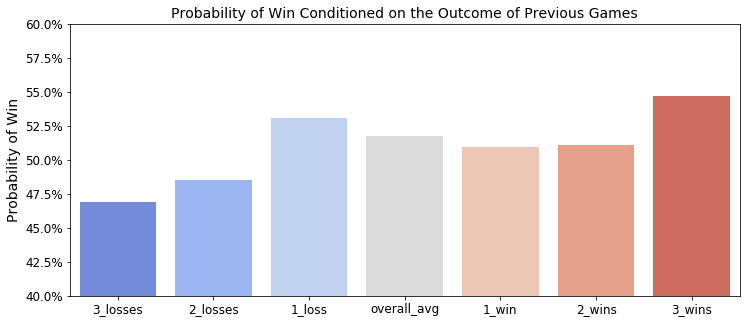

In [92]:
plt.figure(figsize=(12, 5))

sns.barplot(x='variable', y='value', data=melted_results, palette='coolwarm')
plt.ylim([.4,.6])
plt.title('Probability of Win Conditioned on the Outcome of Previous Games', fontsize=14)
plt.ylabel('Probability of Win', fontsize=14)
plt.xlabel('', fontsize=14)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=1))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)


plt.show()

# Amateur Players

In [63]:
# Pull all players 
intermediate_players = ['eono619', 'Isaac1969', 'Truva1915', 'DoktorMatt', 'souzvv2000', 'Akkiee',
                       'svves', 'Sergei_333', 'RRJD4163', 'giantreign']

name = []
loss_3 = []
loss_2 = []
loss_1 = []
avg = []
win_1 = []
win_2 = []
win_3 = []
serial_r = []
serial_pval = []

n_loss_3 = []
n_loss_2 = []
n_loss_1 = []
n_avg = []
n_win_1 = []
n_win_2 = []
n_win_3 = []

for player in intermediate_players:
    print(player)
    # Get data
    df = get_games(player, 1500)

    # Clean, lag, add logic
    df = clean_df(df)
    all_df = get_lagged_df(df)
    final_df =  add_dates_wins_losses_checks(all_df)
    
    corr, pval = get_serial_corr(df)
    
    # Pull probs  
    name.append(player)
    loss_3.append(round(final_df[final_df['3_losses']].points.mean(),2))
    loss_2.append(round(final_df[final_df['2_losses']].points.mean(),2))
    loss_1.append(round(final_df[final_df['1_loss']].points.mean(),2))
    avg.append(round(final_df['points'].mean(),2))
    win_1.append(round(final_df[final_df['1_win']].points.mean(),2))
    win_2.append(round(final_df[final_df['2_wins']].points.mean(),2))
    win_3.append(round(final_df[final_df['3_wins']].points.mean(),2))
    serial_r.append(round(corr,2))
    serial_pval.append(round(pval,2))
    
    # Pull sizes 
    n_loss_3.append(len(final_df[final_df['3_losses']].points))
    n_loss_2.append(len(final_df[final_df['2_losses']].points))
    n_loss_1.append(len(final_df[final_df['1_loss']].points))
    n_avg.append(len(final_df['points']))
    n_win_1.append(len(final_df[final_df['1_win']].points))
    n_win_2.append(len(final_df[final_df['2_wins']].points))
    n_win_3.append(len(final_df[final_df['3_wins']].points))
    
    

d_probs = {'player': name,
     '3_losses': loss_3,
     '2_losses': loss_2,
     '1_loss': loss_1,
     'overall_avg': avg, 
     '1_win': win_1,
     '2_wins': win_2,
     '3_wins': win_3,
     'serial_r': serial_r, 
     'serial_pval': serial_pval
}

d_sizes = {'player': name,
     '3_losses': n_loss_3,
     '2_losses': n_loss_2,
     '1_loss': n_loss_1,
     'overall_avg': n_avg, 
     '1_win': n_win_1,
     '2_wins': n_win_2,
     '3_wins': n_win_3,
     'serial_r': serial_r, 
     'serial_pval': serial_pval
}


eono619
Isaac1969
Truva1915
DoktorMatt
souzvv2000
Akkiee
svves
Sergei_333
RRJD4163
giantreign


In [64]:
probs_df = pd.DataFrame(d_probs)
probs_df.columns = ['player', 'p(win|3 losses)', 'p(win|2 losses)', 'p(win|1 loss)', 'p(win)',
                   'p(win|1 win)', 'p(win|2 wins)', 'p(win|3 wins)', 'serial corr', 'pvalue']

sizes_df = pd.DataFrame(d_sizes)
sizes_df.columns = ['player', 'p(win|3 losses)', 'p(win|2 losses)', 'p(win|1 loss)', 'p(win)',
                   'p(win|1 win)', 'p(win|2 wins)', 'p(win|3 wins)', 'serial corr', 'pvalue']

,player,p(win|3 losses),p(win|2 losses),p(win|1 loss),p(win),p(win|1 win),p(win|2 wins),p(win|3 wins),serial corr,pvalue
0,eono619,0.47,0.48,0.53,0.52,0.51,0.51,0.55,-0.02,0.49
1,Isaac1969,0.26,0.33,0.43,0.56,0.65,0.66,0.69,0.22,0.00
2,Truva1915,0.46,0.48,0.50,0.50,0.50,0.49,0.49,-0.01,0.86
3,DoktorMatt,0.42,0.44,0.47,0.50,0.53,0.50,0.53,0.06,0.04
4,souzvv2000,0.47,0.45,0.48,0.50,0.51,0.52,0.51,0.03,0.32
5,Akkiee,0.51,0.52,0.51,0.49,0.48,0.52,0.57,-0.03,0.21
6,svves,0.54,0.50,0.48,0.49,0.49,0.49,0.51,-0.01,0.77
7,Sergei_333,0.48,0.48,0.48,0.50,0.52,0.50,0.46,0.03,0.36
8,RRJD4163,0.50,0.51,0.51,0.50,0.50,0.52,0.50,-0.03,0.30
9,giantreign,0.51,0.50,0.52,0.51,0.50,0.48,0.50,-0.01,0.79


In [70]:
display = {'player': probs_df.player,
    'p(win|3 losses)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|3 losses)'] , sizes_df['p(win|3 losses)'])],
    'p(win|2 losses)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|2 losses)'] , sizes_df['p(win|2 losses)'])],           
    'p(win|1 loss)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|1 loss)'] , sizes_df['p(win|1 loss)'])],           
    'p(win)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win)'] , sizes_df['p(win)'])],           
    'p(win|1 win)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|1 win)'] , sizes_df['p(win|1 win)'])],
    'p(win|2 wins)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|2 wins)'] , sizes_df['p(win|2 wins)'])],           
    'p(win|3 wins)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|3 wins)'] , sizes_df['p(win|3 wins)'])],                      
    'serial corr': [str(corr)+'*' if pval<.05 else str(corr) for corr,pval in zip(probs_df['serial corr'], probs_df['pvalue'])  ]
          }

weighted_means = {
    'player': 'Weighted Mean:', 
    'p(win|3 losses)': [get_weighted_mean(probs_df['p(win|3 losses)'] , sizes_df['p(win|3 losses)'])],
    'p(win|2 losses)': [get_weighted_mean(probs_df['p(win|2 losses)'] , sizes_df['p(win|2 losses)'])],           
    'p(win|1 loss)': [get_weighted_mean(probs_df['p(win|1 loss)'] , sizes_df['p(win|1 loss)'])],           
    'p(win)': [get_weighted_mean(probs_df['p(win)'] , sizes_df['p(win)'])],           
    'p(win|1 win)': [get_weighted_mean(probs_df['p(win|1 win)'] , sizes_df['p(win|1 win)'])],
    'p(win|2 wins)': [get_weighted_mean(probs_df['p(win|2 wins)'] , sizes_df['p(win|2 wins)'])],           
    'p(win|3 wins)': [get_weighted_mean(probs_df['p(win|3 wins)'] , sizes_df['p(win|3 wins)'])],
    'serial corr': ['']
}


pd.concat([pd.DataFrame(display), pd.DataFrame(weighted_means)])

,player,p(win|3 losses),p(win|2 losses),p(win|1 loss),p(win),p(win|1 win),p(win|2 wins),p(win|3 wins),serial corr
0,eono619,0.47 (98),0.48 (198),0.53 (442),0.52 (953),0.51 (474),0.51 (233),0.55 (117),-0.02
1,Isaac1969,0.26 (233),0.33 (349),0.43 (629),0.56 (1491),0.65 (797),0.66 (500),0.69 (319),0.22*
2,Truva1915,0.46 (140),0.48 (282),0.5 (591),0.5 (1234),0.5 (593),0.49 (282),0.49 (135),-0.01
3,DoktorMatt,0.42 (170),0.44 (326),0.47 (673),0.5 (1492),0.53 (665),0.5 (318),0.53 (148),0.06*
4,souzvv2000,0.47 (191),0.45 (357),0.48 (713),0.5 (1495),0.51 (721),0.52 (352),0.51 (173),0.03
5,Akkiee,0.51 (166),0.52 (355),0.51 (747),0.49 (1500),0.48 (723),0.52 (337),0.57 (171),-0.03
6,svves,0.54 (157),0.5 (330),0.48 (672),0.49 (1384),0.49 (642),0.49 (297),0.51 (136),-0.01
7,Sergei_333,0.48 (150),0.48 (299),0.48 (602),0.5 (1257),0.52 (608),0.5 (303),0.46 (144),0.03
8,RRJD4163,0.5 (143),0.51 (309),0.51 (668),0.5 (1420),0.5 (664),0.52 (306),0.5 (148),-0.03
9,giantreign,0.51 (146),0.5 (301),0.52 (643),0.51 (1345),0.5 (670),0.48 (330),0.5 (156),-0.01


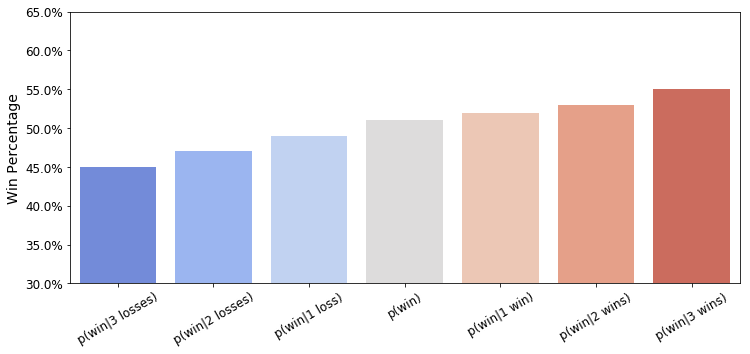

In [91]:
melted = pd.melt(pd.DataFrame(weighted_means)[['player', 'p(win|3 losses)', 'p(win|2 losses)', 
                                              'p(win|1 loss)', 'p(win)', 'p(win|1 win)', 
                                              'p(win|2 wins)', 'p(win|3 wins)']],
                 id_vars='player', 
                 value_vars = ['p(win|3 losses)', 'p(win|2 losses)', 'p(win|1 loss)', 'p(win)',
                   'p(win|1 win)', 'p(win|2 wins)', 'p(win|3 wins)']
                )
plt.figure(figsize=(12, 5))

sns.barplot(x='variable', y='value', data=melted, palette='coolwarm')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Win Percentage', fontsize=14)
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.ylim(.3, .65)
plt.show()

In [29]:
analyze_runs(final_df.points)

(477.0, 522, 0.7212251688486686)

# Pro Players

In [ ]:
# Pull all players 
gms = ['VincentKeymer2004', 'Feokl1995', 'NeverEnough', 'MrBochwalt', 
                        'cutemouse83', 'IVK88', 'Multibrendovyi', 'may6enexttime', 
                        'RealDavidNavara', 'sumsar42']

name = []
loss_3 = []
loss_2 = []
loss_1 = []
avg = []
win_1 = []
win_2 = []
win_3 = []
serial_r = []
serial_pval = []

n_loss_3 = []
n_loss_2 = []
n_loss_1 = []
n_avg = []
n_win_1 = []
n_win_2 = []
n_win_3 = []

for player in gms:
    print(player)
    # Get data
    df = get_games(player, 1500)

    # Clean, lag, add logic
    df = clean_df(df)
    all_df = get_lagged_df(df)
    final_df =  add_dates_wins_losses_checks(all_df)
    
    corr, pval = get_serial_corr(df)
    
    # Pull probs  
    name.append(player)
    loss_3.append(round(final_df[final_df['3_losses']].points.mean(),2))
    loss_2.append(round(final_df[final_df['2_losses']].points.mean(),2))
    loss_1.append(round(final_df[final_df['1_loss']].points.mean(),2))
    avg.append(round(final_df['points'].mean(),2))
    win_1.append(round(final_df[final_df['1_win']].points.mean(),2))
    win_2.append(round(final_df[final_df['2_wins']].points.mean(),2))
    win_3.append(round(final_df[final_df['3_wins']].points.mean(),2))
    serial_r.append(round(corr,2))
    serial_pval.append(round(pval,2))
    
    # Pull sizes 
    n_loss_3.append(len(final_df[final_df['3_losses']].points))
    n_loss_2.append(len(final_df[final_df['2_losses']].points))
    n_loss_1.append(len(final_df[final_df['1_loss']].points))
    n_avg.append(len(final_df['points']))
    n_win_1.append(len(final_df[final_df['1_win']].points))
    n_win_2.append(len(final_df[final_df['2_wins']].points))
    n_win_3.append(len(final_df[final_df['3_wins']].points))
    
    

d_probs = {'player': name,
     '3_losses': loss_3,
     '2_losses': loss_2,
     '1_loss': loss_1,
     'overall_avg': avg, 
     '1_win': win_1,
     '2_wins': win_2,
     '3_wins': win_3,
     'serial_r': serial_r, 
     'serial_pval': serial_pval
}

d_sizes = {'player': name,
     '3_losses': n_loss_3,
     '2_losses': n_loss_2,
     '1_loss': n_loss_1,
     'overall_avg': n_avg, 
     '1_win': n_win_1,
     '2_wins': n_win_2,
     '3_wins': n_win_3,
     'serial_r': serial_r, 
     'serial_pval': serial_pval
}


VincentKeymer2004
Feokl1995
NeverEnough
MrBochwalt
cutemouse83
IVK88
Multibrendovyi
may6enexttime
RealDavidNavara
sumsar42


In [103]:
probs_df = pd.DataFrame(d_probs)
probs_df.columns = ['player', 'p(win|3 losses)', 'p(win|2 losses)', 'p(win|1 loss)', 'p(win)',
                   'p(win|1 win)', 'p(win|2 wins)', 'p(win|3 wins)', 'serial corr', 'pvalue']

sizes_df = pd.DataFrame(d_sizes)
sizes_df.columns = ['player', 'p(win|3 losses)', 'p(win|2 losses)', 'p(win|1 loss)', 'p(win)',
                   'p(win|1 win)', 'p(win|2 wins)', 'p(win|3 wins)', 'serial corr', 'pvalue']

In [104]:
display = {'player': probs_df.player,
    'p(win|3 losses)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|3 losses)'] , sizes_df['p(win|3 losses)'])],
    'p(win|2 losses)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|2 losses)'] , sizes_df['p(win|2 losses)'])],           
    'p(win|1 loss)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|1 loss)'] , sizes_df['p(win|1 loss)'])],           
    'p(win)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win)'] , sizes_df['p(win)'])],           
    'p(win|1 win)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|1 win)'] , sizes_df['p(win|1 win)'])],
    'p(win|2 wins)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|2 wins)'] , sizes_df['p(win|2 wins)'])],           
    'p(win|3 wins)': [str(i) + ' ('+str(j)+')' for i, j in zip(probs_df['p(win|3 wins)'] , sizes_df['p(win|3 wins)'])],                      
    'serial corr': [str(corr)+'*' if pval<.05 else str(corr) for corr,pval in zip(probs_df['serial corr'], probs_df['pvalue'])  ]
          }

weighted_means = {
    'player': 'Weighted Mean:', 
    'p(win|3 losses)': [get_weighted_mean(probs_df['p(win|3 losses)'] , sizes_df['p(win|3 losses)'])],
    'p(win|2 losses)': [get_weighted_mean(probs_df['p(win|2 losses)'] , sizes_df['p(win|2 losses)'])],           
    'p(win|1 loss)': [get_weighted_mean(probs_df['p(win|1 loss)'] , sizes_df['p(win|1 loss)'])],           
    'p(win)': [get_weighted_mean(probs_df['p(win)'] , sizes_df['p(win)'])],           
    'p(win|1 win)': [get_weighted_mean(probs_df['p(win|1 win)'] , sizes_df['p(win|1 win)'])],
    'p(win|2 wins)': [get_weighted_mean(probs_df['p(win|2 wins)'] , sizes_df['p(win|2 wins)'])],           
    'p(win|3 wins)': [get_weighted_mean(probs_df['p(win|3 wins)'] , sizes_df['p(win|3 wins)'])],
    'serial corr': ['']
}


pd.concat([pd.DataFrame(display), pd.DataFrame(weighted_means)])

,player,p(win|3 losses),p(win|2 losses),p(win|1 loss),p(win),p(win|1 win),p(win|2 wins),p(win|3 wins),serial corr
0,VincentKeymer2004,0.45 (19),0.54 (50),0.59 (150),0.64 (503),0.66 (291),0.69 (177),0.71 (112),0.08
1,Feokl1995,0.4 (21),0.48 (47),0.64 (152),0.7 (585),0.74 (382),0.77 (265),0.77 (193),0.08
2,deacbogdan1,0.7 (5),0.66 (16),0.72 (67),0.72 (299),0.74 (197),0.73 (133),0.77 (89),-0.02
3,MrBochwalt,0.66 (16),0.68 (63),0.66 (234),0.71 (988),0.73 (641),0.76 (438),0.77 (313),0.06
4,cutemouse83,0.56 (26),0.61 (85),0.65 (326),0.7 (1499),0.71 (926),0.73 (591),0.72 (386),0.04
5,gsvc,nan (0),1.0 (4),0.85 (33),0.8 (199),0.8 (153),0.79 (117),0.8 (89),-0.03
6,Multibrendovyi,0.64 (35),0.57 (96),0.59 (274),0.66 (945),0.68 (571),0.71 (363),0.7 (239),0.1*
7,may6enexttime,0.4 (15),0.61 (44),0.69 (161),0.71 (650),0.72 (434),0.77 (293),0.77 (211),0.05
8,SalgadoChess,0.6 (5),0.67 (15),0.66 (51),0.71 (241),0.74 (153),0.75 (98),0.79 (63),0.11
9,sumsar42,0.83 (6),0.62 (17),0.71 (75),0.77 (402),0.8 (295),0.83 (226),0.84 (180),0.07


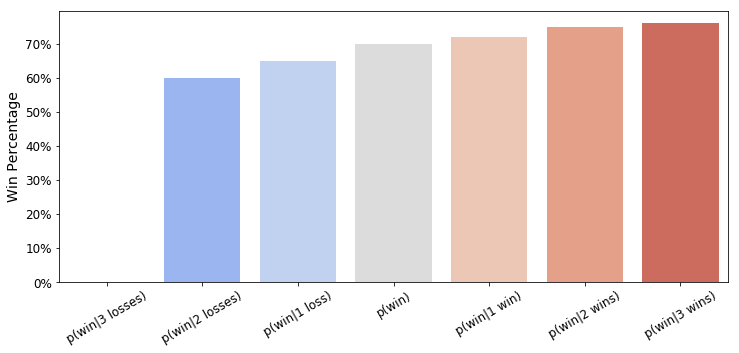

In [105]:
melted = pd.melt(pd.DataFrame(weighted_means)[['player', 'p(win|3 losses)', 'p(win|2 losses)', 
                                              'p(win|1 loss)', 'p(win)', 'p(win|1 win)', 
                                              'p(win|2 wins)', 'p(win|3 wins)']],
                 id_vars='player', 
                 value_vars = ['p(win|3 losses)', 'p(win|2 losses)', 'p(win|1 loss)', 'p(win)',
                   'p(win|1 win)', 'p(win|2 wins)', 'p(win|3 wins)']
                )
plt.figure(figsize=(12, 5))

sns.barplot(x='variable', y='value', data=melted, palette='coolwarm')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Win Percentage', fontsize=14)
plt.xticks(rotation=30, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
#plt.ylim(.3, .65)
plt.show()